In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import torchvision
from torch import nn
from torch.nn import functional as F

/home/aoijays/miniconda3/envs/torch/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


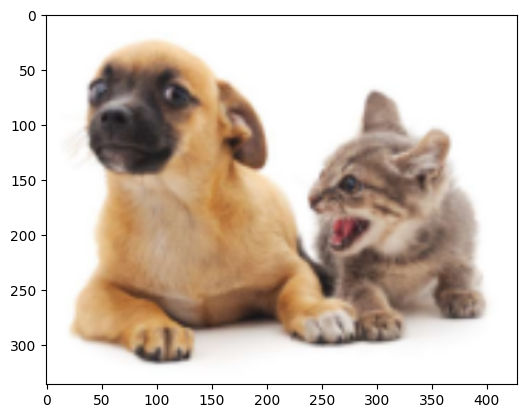

In [2]:
img = plt.imread('data/dog_cat.png')
plt.imshow(img)

In [3]:
def box_center_to_corner(boxes):
    x,y,w,h = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    boxes = torch.stack((x - w/2, y - h/2, x + w/2, y + h/2), axis = -1)
    return boxes

def box_corner_to_center(boxes):
    lx,ly,rx,ry = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    boxes = torch.stack(((lx+rx)/2, (ly+ry)/2, (rx-lx), (ry-ly)), axis = -1)
    return boxes


dog_bbox, cat_bbox = [30., 30., 220., 310.0], [250., 80.0, 380.0, 300.0]
boxes = torch.tensor( (dog_bbox, cat_bbox) )

box_center_to_corner( box_corner_to_center(boxes) ) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

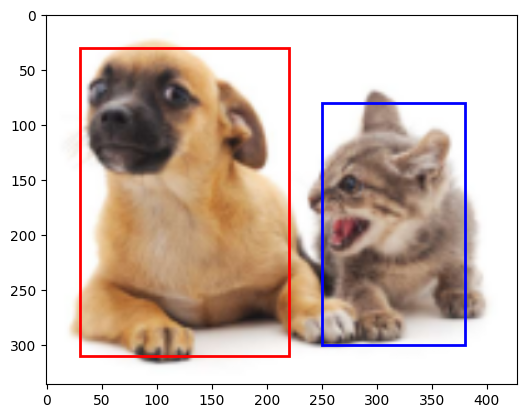

In [4]:
def draw_bbox(bbox, color):
    return plt.Rectangle(
        xy= ( bbox[0], bbox[1] ), 
        width = bbox[2] - bbox[0], height = bbox[3] - bbox[1], 
        fill=False, edgecolor = color, linewidth=2
    )

fig = plt.imshow(img)
fig.axes.add_patch( draw_bbox(dog_bbox, 'red') )
fig.axes.add_patch( draw_bbox(cat_bbox, 'blue') )

In [5]:
import os
import pandas as pd

In [6]:
def read_data(is_Train=True):

    data_dir = 'data/banana-detection'
    data_dir = os.path.join( data_dir, 'bananas_train' if is_Train else 'bananas_val')
    csv_dir = os.path.join(data_dir, 'label.csv')

    # 设定索引 其他列为值
    csv_data = pd.read_csv(csv_dir).set_index('img_name')
    
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        targets.append(list(target))
        images.append(
            torchvision.io.read_image(
                os.path.join(data_dir, "images", img_name)
            )
        )
    
    return images, torch.tensor(targets).unsqueeze(1)/256
        

In [7]:
class BananaDataset(Dataset):
    def __init__(self, isTrain) -> None:
        super().__init__()
        print('reading ' + ('training examples' if isTrain else 'validation examples'))
        self.features, self.labels = read_data(isTrain)
        print (f'reading {len(self.features)} examples') 
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx].float(), self.labels[idx]

In [8]:
batch_size = 32
train_loader = DataLoader(BananaDataset(isTrain=True), batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(BananaDataset(isTrain=False), batch_size, num_workers=4)

reading training examples
reading 1000 examples
reading validation examples
reading 100 examples


torch.Size([32, 3, 256, 256])
torch.Size([32, 1, 5])


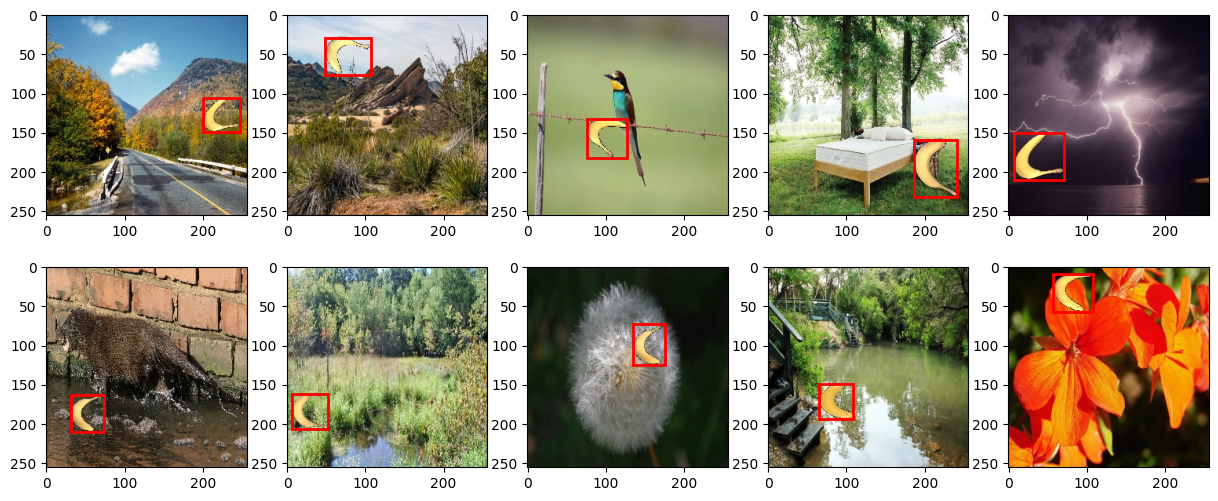

In [9]:
x = next(iter(train_loader))
print(x[0].shape)
print(x[1].shape)
images = x[0]  # torch.Size([32, 3, 256, 256])
labels = x[1]  # torch.Size([32, 1, 5])

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
edge_size = 256

for i in range(10):
    img = images[i].permute(1, 2, 0).numpy() / 255  # 将图像维度从 (C, H, W) 转换为 (H, W, C)
    ax = axes[i // 5, i % 5]  # 确定子图的位置
    ax.add_patch( draw_bbox(labels[i][0][1:5] * edge_size, 'red') )
    ax.imshow(img)  # 显示图像
plt.show()


In [10]:
def multibox_prior(data, sizes, ratios):
   
    in_height, in_width = data.shape[-2:] # feature map的高宽 
    device, sizes_len, ratios_len = data.device, len(sizes), len(ratios)
    
    # 每个像素生成的锚框    
    boxes_per_pixel = sizes_len + ratios_len - 1
    sizes = torch.tensor(sizes, device=device)
    ratios = torch.tensor(ratios, device=device)
    
    # 计算单位距离（步长）
    steps_h, steps_w = 1.0 / in_height, 1.0 / in_width
    
    # 所有像素的中心坐标 
    # 第0,1,2,3,4...i个像素 
    # 中心在(i+0.5)*step
    
    center_h = (torch.arange(in_height, device=device) + 0.5) * steps_h
    center_w = (torch.arange(in_width, device=device) + 0.5) * steps_w
    
    # 两两配对 变成网格
    shift_x, shift_y = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)
    
    # 单个锚框的高宽组合
    w = torch.cat((sizes * torch.sqrt(ratios[0]), sizes[0] * torch.sqrt(ratios[1:]))) * in_height / in_width  # 处理矩形输入
    h = torch.cat((sizes / torch.sqrt(ratios[0]), sizes[0] / torch.sqrt(ratios[1:])))
   
    # 除以2来获得半高和半宽 重复in_height * in_width个像素次
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat( in_height * in_width, 1) / 2 
    
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    
    return output.unsqueeze(0)

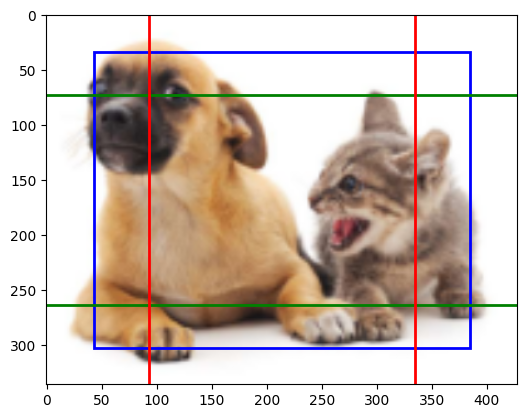

In [11]:
img = plt.imread('data/dog_cat.png')
h,w = img.shape[:2]


def show_bboxes(img, anchors, fmap_w, fmap_h):

    fig = plt.imshow(img)
    nums = len(anchors) // (fmap_w * fmap_h)
    colors = ['b','g','r','c','m','y','k','w'][:nums]
    
    for i in range(len(anchors)):
        fig.axes.add_patch( draw_bbox(anchors[i], colors[i%nums]) )
    
    
def display_anchors(fmap_w, fmap_h, s):
    fmap = torch.zeros((1, 10, fmap_h, fmap_w)) # [batch_size, channels, h, w]
    
    anchors = multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5]) # 指定s和r生成锚框
    bbox_scale = torch.tensor((w, h, w, h))
    show_bboxes(img, anchors[0] * bbox_scale, fmap_w, fmap_h) # 乘上实际大小
    
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

In [12]:
def box_iou(boxes1, boxes2):

    # lambda 表达式 计算矩形面积
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]))

    
    areas1 = box_area(boxes1) # 面积1
    areas2 = box_area(boxes2) # 面积2

    # 求交集
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

In [13]:
# 分配锚框 边界框
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]

    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device)
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

In [14]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = box_corner_to_center(anchors) # 转化为center方式
    c_assigned_bb = box_corner_to_center(assigned_bb) # 转化为center方式
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:] # 计算offset
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [15]:
#@save
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [16]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)
    
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [17]:
def down_sample_blk(in_channels, out_channels): #VGG Block
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [18]:
block = down_sample_blk(3, 10)
block( torch.zeros(32, 3, 100, 100) ).shape

torch.Size([32, 10, 50, 50])

In [19]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

block = base_net()
block( torch.zeros(32, 3, 256, 256) ).shape

torch.Size([32, 64, 32, 32])

In [20]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i <= 3:
        blk = down_sample_blk(128, 128)
    else:
        blk = nn.AdaptiveMaxPool2d((1,1))
    return blk



In [21]:
from numpy import size


sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs) -> None:
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.blk, self.cls, self.predictor = nn.ModuleList(), nn.ModuleList(), nn.ModuleList()
        
        in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            self.blk.append( get_blk(i) )
            self.cls.append( nn.Conv2d( in_channels[i], num_anchors * (num_classes + 1), kernel_size=3, padding=1) )
            self.predictor.append( nn.Conv2d( in_channels[i], num_anchors * 4, kernel_size=3, padding=1) )
    
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X = self.blk[i](X)
            anchors[i] = multibox_prior(X, sizes = sizes[i], ratios = ratios[i] ) # 锚框
            cls_preds[i] = self.cls[i](X) # 分类结果
            bbox_preds[i] = self.predictor[i](X) # 回归结果
        
        # 整理
        anchors = torch.cat(anchors, dim = 1)
        
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            cls_preds.shape[0], -1, self.num_classes + 1
        )
        
        bbox_preds = concat_preds(bbox_preds)
        
        return anchors, cls_preds, bbox_preds                
            
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# device = 'cpu'

trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)
cls_loss = nn.CrossEntropyLoss(reduction='none') # 不合并 
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(
        cls_preds.reshape(-1, num_classes),
        cls_labels.reshape(-1)
    ).reshape(batch_size, -1).mean(dim=1)
    
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

cpu


In [23]:
# 准确率
def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

# 相对误差
def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

In [24]:
num_epochs = 20

net = net.to(device)
for epoch in range(num_epochs):
    net.train()

    for features, target in train_loader:
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)

        anchors, cls_preds, bbox_preds = net(X)
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        
        trainer.step()

    
    print(f'epoch {epoch} / {num_epochs}: traing loss = {l.mean()} acc = {cls_eval(cls_preds, cls_labels)/cls_labels.numel()} mas = {bbox_eval(bbox_preds, bbox_labels, bbox_masks)/bbox_labels.numel()}\n')

epoch 0 / 20: traing loss = 0.04621583968400955 acc = 0.9954307494489346 mas = 0.004976299910927239

epoch 1 / 20: traing loss = 0.03666697070002556 acc = 0.9951322556943424 mas = 0.004746724366265829

epoch 2 / 20: traing loss = 0.04361150786280632 acc = 0.9943975018368847 mas = 0.005404535415503666



KeyboardInterrupt: 

In [ ]:
torch.cuda.device_count()

0